In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import os
import math
import matplotlib.pyplot as plt

import numpy as np

from Load_Data import load_data

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
device = torch.device(device)
print(f"Using {device} device")

Using cuda device


# Load Data

In [7]:
def get_data_loaders(batch_size=256, faste_files_to_load=37, normalize=False):
    Data = load_data(data_dir=os.path.join(os.getcwd(), 'Data', 'Parsed_Data_Mean'), 
                     train_val_data_to_load=math.inf,
                     test_data_to_load=math.inf,
                     faste_files_to_load=faste_files_to_load,
                     normalize=normalize)
    
    training_dataset, validation_dataset, testing_dataset = Data

    train_loader = DataLoader(dataset=training_dataset,
                              batch_size=batch_size,shuffle=True)
    val_loader = DataLoader(dataset=validation_dataset,
                              batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(dataset=testing_dataset,
                              batch_size=batch_size,shuffle=True)
    return train_loader, val_loader, test_loader

faste_files_to_load = 37
normalize = False
train_loader, val_loader, test_loader = get_data_loaders(faste_files_to_load=faste_files_to_load, normalize=normalize)

Loading sequences from sequences.fasta
Loading coverage from SRX9770776.faste
Loading coverage from SRX9770789.faste
Loading coverage from SRX9770788.faste
Loading coverage from SRX9770777.faste
Loading coverage from SRX9770785.faste
Loading coverage from SRX9770782.faste
Loading coverage from SRX9770790.faste
Loading coverage from SRX9770791.faste
Loading coverage from SRX9770783.faste
Loading coverage from SRX9770784.faste
Loading coverage from SRX9770793.faste
Loading coverage from SRX9770786.faste
Loading coverage from SRX9770779.faste
Loading coverage from SRX9770781.faste
Loading coverage from SRX9770780.faste
Loading coverage from SRX9770778.faste
Loading coverage from SRX9770787.faste
Loading coverage from SRX9770792.faste
Loading coverage from SRX9770775.faste
Loading coverage from SRX9770774.faste
Loading coverage from SRX9770773.faste
Loading coverage from SRX391994.faste
Loading coverage from SRX391993.faste
Loading coverage from SRX391992.faste
Loading coverage from SRX391

In [ ]:
train_loader.dataset[100]


# Build Model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_kernels=[1024, 512, 256], kernel_size=[512,256,128],
                 dropout=0):
        super(SimpleCNN, self).__init__()
        self.input_channels=4
        self.num_kernels=num_kernels
        self.kernel_size=kernel_size
        self.dropout=dropout
        self.conv_block = nn.Sequential(
            # first layer
            nn.Conv1d(in_channels=self.input_channels,
                      out_channels=num_kernels[0],
                      kernel_size=kernel_size[0]),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.MaxPool1d(kernel_size=2),
        )
        self.regression_block = nn.Sequential(
            nn.Linear(num_kernels[0], 37),
            nn.ReLU(),  # ReLU ensures positive outputs
            # nn.LogSoftmax(dim=1)  # Apply log softmax if necessary for your task
        )  

    def forward(self, x):
        x = self.conv_block(x)
        x,_ = torch.max(x, dim=2)        
        x = self.regression_block(x)
        return x

In [13]:
class LocalDnaCnn(nn.Module):
    def __init__(self, num_kernels=[128, 64, 32, 16], kernel_size=[128,96,64,32],
                 dropout=0):
        super(LocalDnaCnn, self).__init__()
        self.input_channels=4
        self.num_kernels=num_kernels
        self.kernel_size=kernel_size
        self.dropout=dropout
        self.conv_block = nn.Sequential(
            # first layer
            nn.Conv1d(in_channels=self.input_channels,
                      out_channels=num_kernels[0],
                      kernel_size=kernel_size[0]),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.MaxPool1d(kernel_size=2),
        )
        # second layer
        self.conv_block.append(nn.Sequential(
            nn.Conv1d(in_channels=self.num_kernels[0],
                      out_channels=num_kernels[1],
                      kernel_size=kernel_size[1]),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=self.dropout),            
        ))
        # Add a third convolutional layer
        self.conv_block.append(nn.Sequential(
            # second layer
            nn.Conv1d(in_channels=self.num_kernels[1],
                      out_channels=num_kernels[2],
                      kernel_size=kernel_size[2]),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=self.dropout),            
        ))
        # Add a fourth convolutional layer
        self.conv_block.append(nn.Sequential(
            nn.Conv1d(in_channels=self.num_kernels[2],
                      out_channels=num_kernels[3],
                      kernel_size=kernel_size[3]),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=self.dropout),            
        ))
        self.regression_block = nn.Sequential(
            nn.Linear(num_kernels[3], num_kernels[3]),
            nn.Linear(num_kernels[3], faste_files_to_load),
            nn.ReLU(),  # ReLU ensures positive outputs
        )  

    def forward(self, x):
        x = self.conv_block(x)
        x,_ = torch.max(x, dim=2)        
        x = self.regression_block(x)
        return x

# Train Model

### Training functions

In [ ]:
def train_epoch(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader)
    num_batches = len(dataloader)
    total_loss = 0
    # set the model to training mode - important when you have 
    # batch normalization and dropout layers
    model.train()
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # Compute prediction and loss
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        # backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0 :
        print(f"training loss: {total_loss/num_batches:>7f}")
    return total_loss / num_batches

def validation(dataloader, model, loss_fn, epoch):
    # set the model to evaluation mode 
    model.eval()
    # size of dataset
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss, correct = 0, 0
    # Evaluating the model with torch.no_grad() ensures that no gradients 
    # are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage 
    # for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            validation_loss += loss_fn(y_pred, y).item()
    validation_loss /= num_batches
    if epoch%10 == 0 :
        print(f"Validation Loss: {validation_loss:>8f} \n")
    return validation_loss

def train_model(train_loader, val_loader, model, optimizer, epochs, patience=10):
    loss_fn = nn.PoissonNLLLoss(log_input=True, full=True)
    p = patience

    train_loss = []
    validation_loss = []
    best_loss = math.inf
    for t in range(epochs):
        if t % 10 == 0 :
            print(f"Epoch {t}\n-------------------------------")
        loss = train_epoch(train_loader, model, loss_fn, optimizer, t)
        train_loss.append(loss)
        loss = validation(val_loader, model, loss_fn, t)
        validation_loss.append(loss)
    
        if train_loss[-1] < validation_loss[-1]:
            # print(f"Training loss {train_loss[-1]} is less than validation loss {validation_loss[-1]}")

            if train_loss[-1]/validation_loss[-1] < 0.5:
                print(f"Training loss {train_loss[-1]} is less than half of validation loss {validation_loss[-1]}")
                p -= 1
                
    print("Done!")

    def plot_loss(train_loss, validation_loss):
        plt.figure(figsize=(4,3))
        plt.plot(np.arange(len(train_loss)), train_loss, label='Training')
        plt.plot(np.arange(len(validation_loss)), validation_loss, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        # plt.savefig('')
        plt.show()
    plot_loss(train_loss, validation_loss)


### Train

In [ ]:
model = LocalDnaCnn().to(device)
lr = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_model(train_loader, val_loader, model, optimizer, 500, 10)

Epoch 0
-------------------------------
training loss: 2.762722
Validation Loss: 2.110176 



### Save Model

In [ ]:
torch.save(model, "LocalDnaCnn.pth")

### Validate Model

In [ ]:
model = torch.load("LocalDnaCnn.pth", weights_only=False)
model.to(device)
model.eval()

SimpleCNN(
  (conv_block): Sequential(
    (0): Conv1d(4, 512, kernel_size=(1028,), stride=(1,))
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (regression_block): Sequential(
    (0): Linear(in_features=512, out_features=37, bias=True)
    (1): ReLU()
  )
)

In [ ]:
X, y = next(iter(test_loader))
X = X.to(device)

y = y.to(device)
y_pred = torch.exp(model.forward(X).to(device))

print(y[0])
print(y_pred[0])

loss_fn = nn.PoissonNLLLoss(log_input=False, full=True)
print(loss_fn(y_pred, y))

tensor([0.4244, 0.6031, 0.1221, 0.6085, 0.3524, 0.6740, 0.7017, 0.7134, 0.7767,
        0.5956, 0.5700, 0.4900, 0.5420, 0.4615, 0.1495, 0.2654, 0.5157, 0.5904,
        0.3692, 0.6628, 0.1832, 0.5721, 0.4328, 0.5112, 0.4197, 0.4511, 0.3856,
        0.6273, 0.5380, 0.3620, 0.3886, 0.6849, 0.4930, 0.6741, 0.3457, 0.0000,
        0.5009], device='cuda:0')
tensor([1.0000, 1.1930, 1.0000, 1.1815, 1.0067, 1.0000, 1.2723, 1.2794, 1.0000,
        1.1929, 1.4318, 1.0000, 1.2000, 1.0000, 1.0000, 1.0000, 1.1440, 1.2920,
        1.0145, 1.0775, 1.1078, 1.2554, 1.0000, 1.5216, 1.0000, 1.2144, 1.1440,
        1.6459, 1.0000, 1.0000, 1.1194, 1.0000, 1.4386, 1.7193, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SelectBackward0>)
tensor(1.3179, device='cuda:0', grad_fn=<MeanBackward0>)


In [9]:
i = 2
print('Tissue: Predicted, True')
for s, (y_p, y_t) in enumerate(zip(y_pred[i], y[i])):
    print(f'{s}: {y_p:.3f}, {y_t:.3f}')

Tissue: Predicted, True
0: 1.000, 0.233
1: 1.026, 0.475
2: 1.000, 0.307
3: 1.000, 0.304
4: 1.000, 0.086
5: 1.000, 0.352
6: 1.042, 0.450
7: 1.000, 0.391
8: 1.000, 0.646
9: 1.000, 0.331
10: 1.638, 0.608
11: 1.000, 0.307
12: 1.076, 0.450
13: 1.000, 0.575
14: 1.000, 0.333
15: 1.000, 0.284
16: 1.000, 0.219
17: 1.193, 0.520
18: 1.000, 0.300
19: 1.000, 0.104
20: 1.000, 0.331
21: 1.009, 0.896
22: 1.000, 0.624
23: 1.943, 1.480
24: 1.000, 0.464
25: 1.131, 1.008
26: 1.000, 0.864
27: 2.571, 1.939
28: 1.000, 0.747
29: 1.000, 1.146
30: 1.272, 1.091
31: 1.000, 0.829
32: 1.962, 2.007
33: 2.093, 1.915
34: 1.000, 0.997
35: 1.000, 0.000
36: 1.000, 0.647


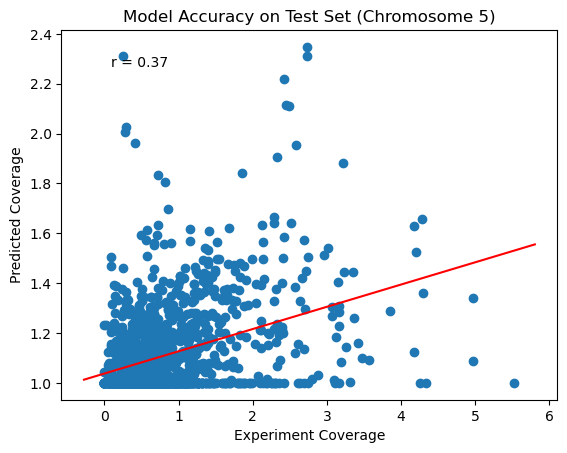

In [ ]:
for _, (X, y) in enumerate(test_loader):
    X, y = X.to(device), y
    y_pred = torch.exp(model(X).to(device))

y = torch.flatten(y).cpu().numpy()
y_pred = torch.flatten(y_pred).cpu().detach().numpy()
pearson_r = np.corrcoef(y, y_pred)[0, 1]

plt.scatter(y, y_pred)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Test Set (Chromosome 5)")
plt.text(0.1, 0.9, f"r^2 = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b = np.polyfit(y, y_pred, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')
plt.savefig('LocalDnaCnnAccuracy.png')
plt.show()

0.0892501179981628

1.0376637028245963